### Directly Download from GC and save as netcdf files
- This is for those who cannot use zarr/python for processing the CMIP6 datasets
- Please note that the netcdf files have CF-compliant time grids, but might not be what you are used to

In [148]:
import numpy as np
import pandas as pd
import os
import gcsfs #google cloud file system. 
import xarray as xr
import warnings
from glob import glob # use * !
import scipy.io as sio

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

In [149]:
from utls import search_df, add_time_info, get_zdict #extra functions

### Initialization

In [224]:
def compute_area_and_seasonal_mean(danom, xlim, ylim, slim, mask=1):
    """
    Weights each grid point by the cos(latitude), computes area mean, normalizing by areaa mean of the weights
    returns:
        DataArray:  global mean for each model
    """  
    xlim = np.array(xlim)
    xlim += (xlim<0 )*360
    if xlim[0]>xlim[1]:
        lon_sel = (danom.lon>=xlim[0])+(danom.lon<xlim[1])
    else:
        #this was previously wrong only when xlim was fully positive or negative -- missing parentheses
        lon_sel = (danom.lon>=xlim[0])*(danom.lon<xlim[1])
    #print(sum(lon_sel.values))
    if type(mask)!=int:
        mask = (xr.ones_like(danom)*mask).isel({'lat': (danom.lat>=ylim[0])*(danom.lat<ylim[1]), 'lon': lon_sel})
    #print(sum(((danom.lat>=ylim[0])*(danom.lat<ylim[1])).values))
    danom = danom.isel({'lat': (danom.lat>=ylim[0])*(danom.lat<ylim[1]), 
                        'lon': lon_sel, 
                        'time': (danom['time'].dt.month >= slim[0])*(danom['time'].dt.month <= slim[1])
                       })
    coslat = np.cos(np.deg2rad(danom.lat))
    #print(coslat)
    weights = xr.ones_like(danom)*coslat*mask
    #print(weights.hus.values)
    weight_mean = weights.mean(['lat','lon'])#, keep_attrs=True, 'plev', 'time'
    #print(weight_mean.hus.values)
    #print('danom*weights')
    #print(danom*weights)
    #print('values')
    #print((danom*weights).hus.values)
    #print('area_mean part 1')
    area_mean = (danom * weights).mean(['lat','lon'], keep_attrs=True, skipna = True)#
    #print(area_mean.hus.values)
    area_mean = area_mean/weight_mean
    #print('area_mean values')
    #print(area_mean.hus.values)
    if area_mean.time.dtype!='datetime64[ns]':
        area_mean['time'] = area_mean.indexes['time'].year
        return area_mean.groupby('time').mean(dim='time', keep_attrs=True)
        #area_mean.indexes['time'].to_datetimeindex()
        #there are lots of dftime.DatetimeNoLeap. this would matter a touch if I used a weighted average.
    else:   
        #month_length = danom.time.dt.days_in_month
        #this actually isn't right! Let's just do an unweighted mean for now :(
        #weights = month_length/sum(month_length[slim[0]:slim[1]+1])
        #Sm = (weights*area_mean)
        #return Sm.groupby(grp).sum(dim='time', keep_attrs=True)
        return area_mean.groupby(area_mean.time.dt.year).mean(dim='time', keep_attrs=True)
    
    #technically this is inconsistent handling; one makes a dimension called "time" and the other makes "years". I have to deal with that in my matlab code
    
plev19 = [100000, 92500, 85000, 70000, 60000, 50000, 40000, 30000, 25000, 20000, 15000, 10000, 7000, 5000, 3000, 2000, 1000, 500, 100]
plev19_bnds = [100000,95000,90000,75000,65000,55000,45000,35000,27000,23000,17000,12500,8500,6500,4000,2500,1500,700,300,100]

In [151]:
#danom = ds0

#xlim = [-20,40]
#ylim = [12,18]
#slim = [7,9]
def calc_stp(dl):
    l = dl.values
    stp = max(l[1:] - l[0:-1])
    return stp

def compute_conv(danom, xlim, ylim, slim, plim):
    """
    Calculates the mean flow convergence of moisture on monthly scale into the Sahel region.
    returns convergence at each pressure level. add pressure level ranges to integrate over.
    """  
    xlim = np.array(xlim)
    xlim += (xlim<0)*360
    lt_stp = calc_stp(danom.lat)
    ln_stp = calc_stp(danom.lon)
    if xlim[0]>xlim[1]:
        lon_sel_2 = (danom.lon>(xlim[0]-ln_stp))+(danom.lon<(xlim[1]+ln_stp))
    else:
        lon_sel_2 = (danom.lon>(xlim[0]-ln_stp))*(danom.lon<(xlim+ln_stp))

    danom = danom.isel({'time': (danom['time'].dt.month >= slim[0])*(danom['time'].dt.month <= slim[1]),
                         'lat': (danom.lat>(ylim[0]-lt_stp))*(danom.lat<(ylim[1]+lt_stp)),
                         'lon': lon_sel_2,
                         'plev': danom.plev==plim #when I can figure out the bounds change this to an integral
                       })
    danom['qfu'] = danom['hus']*danom['ua']
    danom['qfv'] = danom['hus']*danom['va']
    if xlim[0]>xlim[1]:
        lon_sel = (danom.lon>xlim[0])+(danom.lon<xlim[1])
    else:
        lon_sel = (danom.lon>xlim[0])*danom.lon<xlim[1]
    lat_sel = (danom.lat>ylim[0])*(danom.lat<ylim[1])
    danom.load()
    dS = danom['qfv'].isel({'lat': danom.lat<(ylim[0]+lt_stp), 'lon': lon_sel}).mean(['lat'], keep_attrs=True)
    dN = -danom['qfv'].isel({'lat': danom.lat>(ylim[1]-lt_stp), 'lon': lon_sel}).mean(['lat'], keep_attrs=True)
    dW = danom['qfu'].isel({'lat': lat_sel, 'lon': danom.lon<(xlim[0]+ln_stp)}).mean(['lon'], keep_attrs=True)
    dE = -danom['qfu'].isel({'lat': lat_sel, 'lon': danom.lon>(xlim[1]-ln_stp)}).mean(['lon'], keep_attrs=True)
    coslat = np.cos(np.deg2rad(ylim))
    d_conv = (coslat[0]*dS + coslat[1]*dN).sum(['lon'], keep_attrs=True)+(dW+dE).sum(['lat'], keep_attrs=True)
    if d_conv.time.dtype!='datetime64[ns]':
        d_conv['time'] = d_conv.indexes['time'].year
        return d_conv.groupby('time').mean(dim='time', keep_attrs=True)
    else:   
        return d_conv.groupby(d_conv.time.dt.year).mean(dim='time', keep_attrs=True)

In [152]:
# Where to write local netcdf files:
username = os.environ['JUPYTERHUB_USER']
mach = os.uname()[1]

zarr_local = f'/home/{username}/netcdf/cmip6/preprocessed'
if not os.path.exists(zarr_local):
    print(f'Please create the directory {zarr_local}')
    

In [153]:
# This is the master CMIP6 Google Cloud catalog
df_cloud = pd.read_csv('https://cmip6.storage.googleapis.com/cmip6-zarr-consolidated-stores-noQC.csv', dtype='unicode')
df_cloud.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,status,severity,issue_url
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,6hrPlev,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706,good,none,none
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsdt,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706,good,none,none
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,prw,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706,good,none,none
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706,good,none,none
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706,good,none,none


### Choose basic configuration parameters

In [225]:
# Here we search the CMIP6 data for the datasets you need - using the same keywords as at the ESGF sites
#       https://esgf-node.llnl.gov/search/cmip6/

debug = False

# must choose ONE table_id  (only works for *mon or *day)
table_id = 'Amon'

#must choose LIST of experiments, variables
experiments = ['historical']#,'hist-aer', , 'hist-nat', 'hist-GHG', 'piControl' 'amip-hist',
variables = ['ts']#, 'va', 'ua']

location = 'Ocean'#'Sahel'#

# can specify 'All' or give a list or string
#sources = ['GFDL-ESM4']#GFDL-CM4']#'ACCESS-ESM1-5']#'CNRM-ESM2-1']#'NorESM2-LM']# 'GFDL-ESM4'['CanESM5-CanOE']#CMCC-CM2-SR5']#'CIESM']#MCM-UA-1-0']  #AWI-CM-1-1-MR']#SAM0-UNICON']# omit the [] to get all models with CESM2 in their name
sources = 'All'
#members = ['r3i1p1f1']#r1i1p1f1']#'r9i1p1f2']#
members = 'All'

In [226]:
search = {'table_id':table_id}
search['experiment_id'] = experiments
search['variable_id'] = variables
if sources != 'All':
    search['source_id'] = sources
if members != 'All':
    search['member_id'] = members
    
df_available = search_df(df_cloud, **search)

print('number of matching datasets',len(df_available))

#523 historical simulations < 536 on the cite directly. Do I want to figure out which simulations are missing? 
# Or do I trust that they are missing for a reason?

number of matching datasets 555


In [227]:
df_available.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,status,severity,issue_url
13151,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r3i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701,good,none,none
13401,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r2i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20180701,good,none,none
21159,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,ts,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701,wontfix,medium,https://errata.es-doc.org/static/view.html?uid...
22165,CMIP,IPSL,IPSL-CM6A-LR,historical,r12i1p1f1,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803,good,none,none
22908,CMIP,IPSL,IPSL-CM6A-LR,historical,r15i1p1f1,Amon,ts,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803,good,none,none


In [228]:
# For proper debugging, it is helpful to add time grid information to dataframe:
if debug:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        dfa = add_time_info(df_available)
else:
    dfa = df_available.copy()

In [229]:
#only use the MASK code for TS!
if location=='Ocean':
    search_mask = {'table_id':'fx'}
    search_mask['experiment_id'] = ['historical', 'piControl', '1pctCO2','hist-resIPO','hist-1950HC']
    search_mask['variable_id'] = ['sftlf']
    if sources != 'All':
        search_mask['source_id'] = sources
    if members != 'All':
        search_mask['member_id'] = members
    historical_mask = search_df(df_cloud, **search_mask)

    print('number of mask datasets',len(historical_mask))

number of mask datasets 464


In [252]:
#only use MASK code for TS!
if location=='Ocean':
    def get_ids(dfa, id_name):
        zdicts = list(map(get_zdict, list(dfa.zstore.values)))
        return set(map(lambda x: (x[id_name], x['grid_label']), zdicts))

    id_name = 'source_id'
    historical_mask_models = get_ids(historical_mask, id_name)
    sst_models = get_ids(dfa, id_name)

    maskable_models = sst_models.intersection(historical_mask_models)

    gsurls = np.array([gsurl for gsurl in dfa.zstore.values if (get_zdict(gsurl)['source_id'], get_zdict(gsurl)['grid_label']) in maskable_models])
    missing = np.array([gsurl for gsurl in dfa.zstore.values if not (get_zdict(gsurl)['source_id'], get_zdict(gsurl)['grid_label']) in maskable_models])

    masks = historical_mask.groupby(['source_id', 'grid_label']).first()

    print(gsurls)


['gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r3i1p1f1/Amon/ts/gr1/v20180701/'
 'gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r2i1p1f1/Amon/ts/gr1/v20180701/'
 'gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/ts/gr1/v20180701/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r12i1p1f1/Amon/ts/gr/v20180803/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r15i1p1f1/Amon/ts/gr/v20180803/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r10i1p1f1/Amon/ts/gr/v20180803/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r11i1p1f1/Amon/ts/gr/v20180803/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/ts/gr/v20180803/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r20i1p1f1/Amon/ts/gr/v20180803/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r17i1p1f1/Amon/ts/gr/v20180803/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r21i1p1f1/Amon/ts/gr/v20180803/'
 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historic

In [253]:
if location=='Ocean':
    print(missing)

['gs://cmip6/CMIP6/CMIP/NUIST/NESM3/historical/r2i1p1f1/Amon/ts/gn/v20190628/'
 'gs://cmip6/CMIP6/CMIP/NUIST/NESM3/historical/r5i1p1f1/Amon/ts/gn/v20190628/'
 'gs://cmip6/CMIP6/CMIP/NUIST/NESM3/historical/r1i1p1f1/Amon/ts/gn/v20190630/'
 'gs://cmip6/CMIP6/CMIP/NUIST/NESM3/historical/r3i1p1f1/Amon/ts/gn/v20190630/'
 'gs://cmip6/CMIP6/CMIP/NUIST/NESM3/historical/r4i1p1f1/Amon/ts/gn/v20190630/'
 'gs://cmip6/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f2/Amon/ts/gn/v20190731/'
 'gs://cmip6/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Amon/ts/gn/v20190731/'
 'gs://cmip6/CMIP6/CMIP/NIMS-KMA/KACE-1-0-G/historical/r1i1p1f1/Amon/ts/gr/v20190910/'
 'gs://cmip6/CMIP6/CMIP/NIMS-KMA/KACE-1-0-G/historical/r3i1p1f1/Amon/ts/gr/v20190919/'
 'gs://cmip6/CMIP6/CMIP/NIMS-KMA/KACE-1-0-G/historical/r2i1p1f1/Amon/ts/gr/v20190920/'
 'gs://cmip6/CMIP6/CMIP/CCCR-IITM/IITM-ESM/historical/r1i1p1f1/Amon/ts/gn/v20191226/'
 'gs://cmip6/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/ts/gn/v20200302/'
 'gs://cmip6/C

In [254]:
# for pr:
if location=='Sahel':
    gsurls = np.array(dfa.zstore.values)

In [255]:
if debug:
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)

    dm = dfa[['experiment_id','source_id','member_id','variable_id','start','stop']].groupby([
             'experiment_id','start','stop','source_id']).nunique()[['member_id']]

    table = pd.DataFrame.pivot_table(dm,
                                     values='member_id',
                                     index=['source_id','start','stop'],
                                     columns=['experiment_id'],
                                     aggfunc=np.sum,
                                     fill_value=0)
    print(table)

In [256]:
dfa.issue_url.unique()

array(['none',
       'https://errata.es-doc.org/static/view.html?uid=2f6b5963-f87e-b2df-a5b0-2f12b6b68d32',
       'https://errata.es-doc.org/static/view.html?uid=5ebabff0-388f-07bc-b2cf-d44dcbb2940f',
       'https://errata.es-doc.org/static/view.html?uid=ad9e4213-f254-e930-a143-030a4b0f8a32',
       'https://errata.es-doc.org/static/view.html?uid=e6b642cf-d449-dfa6-a9da-1d1d1e1c0ecd'],
      dtype=object)

In [257]:
fs = gcsfs.GCSFileSystem(token='anon', access='read_only') #the actual files, not the list of files woohoo FILE SYSTEM
#fs.get_mapper()

In [260]:
#gsurls = dfa.zstore.values #zstore is the url where the data is stored

conv = False
bndries = False
replace = False
start_month = 7
end_month = 9

ds_list = []
ds_failed_list = []

def update_vars(ds):
    for var in [var for var in ds.coords]:
        if 'bounds' in var:
            nvar = var.replace('bounds','bnds')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'latitude' in var:
            nvar = var.replace('latitude','lat')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'longitude' in var:
            nvar = var.replace('longitude','lon')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
    return ds

if conv:
    search_uv = search.copy()
    search_uv['source_id'] = [model]
    search_uv['member_id'] = [run]
    search_u = search_uv.copy()
    search_v = search_uv.copy()
    search_u['variable_id'] = ['ua']
    search_v['variable_id'] = ['va']
    
for gsurl in gsurls:
    zdict = get_zdict(gsurl) #naomi func for metadata
    institution = zdict['institution_id']
    model = zdict['source_id']
    grd = zdict['grid_label']
    run = zdict['member_id']
    variable = zdict['variable_id']
    expt = zdict['experiment_id']
    if conv:
        filename = f'{variable}_conv_925_{institution}_{model}_{run}'
    elif bndries:
        filename = f'{variable}_bndries_{institution}_{model}_{run}'
    else:
        filename = f'{variable}_{institution}_{model}_{run}'
    ncdir = f'{zarr_local}/{expt}/{start_month}-{end_month}'
    ncfile = f'{ncdir}/{filename}.nc'
    
    if(not replace):
        ncfiles = glob(ncfile) #check not to double-download files
        if len(ncfiles) > 0:
            print(ncfiles, 'already exists')
            continue
            
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        ds0 = xr.open_zarr(fs.get_mapper(gsurl),consolidated=True) #gets info about the file. get_mapper! always use consolidated=True
        if variable=='ts':
            mask_ds = xr.open_zarr(fs.get_mapper(masks['zstore'][(model, grd)]),consolidated=True) 
        #if variable=='ta' or variable=='zg':
         #   ds0 = ds0.isel({'plev': ds0.plev==100})
        if conv:
            U = np.array(search_df(df_cloud, **search_u).zstore.values)
            V = np.array(search_df(df_cloud, **search_v).zstore.values)
            if len(U) == 1 and len(V) == 1:
                dsU = xr.open_zarr(fs.get_mapper(U[0]),consolidated=True)
                dsV = xr.open_zarr(fs.get_mapper(V[0]),consolidated=True)
                ds0['va'] = dsV['va']
                ds0['ua'] = dsU['ua']
            else:
                continue
        
    #month_length = ds.time.dt.days_in_month #for some reason the first one doesn't have this...
        
    ds0 = update_vars(ds0)
    
    if location=='Ocean':
        mask_ds = update_vars(mask_ds)
        ls_mask = np.floor(1-mask_ds.sftlf.values/100)
        new_lon = (mask_ds.lon+180)%360-180
        new_mask = (mask_ds.lat>4)*(6*mask_ds.lat - 5*new_lon <164) + (mask_ds.lat<4)*(6*mask_ds.lat + 5*new_lon > -116)
        new_mask = xr.ones_like(ds0)*new_mask.values
        if sum(ds0.lat == new_mask.lat) != ds0.lat.size:
            print('dimension mismatch:', sum(ds0.lat == new_mask.lat).values, '!=', ds0.lat.size)
            continue
    
    try:
        #if variable=='hus':
        #    ds = ds0.isel({'plev':ds0.plev==8.5e4})
        #else:
        ds = ds0
        #THINGS THAT WERE WRONG: NA, TA, W and E
        if location=='Ocean':
            #TODO don't assume it's ts. make NARI and p1 only for ts.
            GG = compute_area_and_seasonal_mean(ds, [-28,20], [-35,15], [start_month, end_month], mask=ls_mask*new_mask)
            NA = compute_area_and_seasonal_mean(ds, [-75,-15], [10,40], [start_month, end_month])
            GT = compute_area_and_seasonal_mean(ds, [0,360],[-20,20],[start_month, end_month], mask=ls_mask)
            SA = compute_area_and_seasonal_mean(ds, [-30, 20], [-20,10], [start_month, end_month], mask=ls_mask)
            md = compute_area_and_seasonal_mean(ds, [-6,36], [30,40], [start_month, end_month], mask=ls_mask)
            TA = compute_area_and_seasonal_mean(ds, [-75,-15], [5,15], [start_month, end_month])
            Sm = NA
            Sm = Sm.rename_vars({'ts':'NA'})
            Sm['GT'] = GT.ts
            if(variable=='ts'):
                Sm['NARI'] = NA.ts - GT.ts
                Sm['p1'] = NA.ts + GT.ts
            Sm['SA'] = SA.ts
            Sm['md'] = md.ts
            Sm['TA'] = TA.ts
            #Sm = GG
            #Sm = Sm.rename_vars({'ts':'GG'})
        elif conv:
            Sm = compute_conv(ds, [-20,40], [12,18], [start_month, end_month], 92500)
        elif bndries:
            Sm = compute_area_and_seasonal_mean(ds, [-20,40], [12-calc_stp(ds.lat), 12], [start_month, end_month])
            Sm = Sm.rename_vars({variable:(variable+'_South')})
            N = compute_area_and_seasonal_mean(ds, [-20,40], [18, 18+calc_stp(ds.lat)], [start_month, end_month])
            Sm[variable+'_North'] = N[variable]
            W = compute_area_and_seasonal_mean(ds, [-20-calc_stp(ds.lon), -20], [12,18], [start_month, end_month])
            Sm[variable+'_West'] = W[variable]
            E = compute_area_and_seasonal_mean(ds, [40, 40+calc_stp(ds.lon)], [12,18], [start_month, end_month])
            Sm[variable+'_East'] = E[variable]
        else:
            Sm = compute_area_and_seasonal_mean(ds, [-20,40], [12,18], [start_month, end_month])
  
    except ValueError:
        print(f'value error for {ncfile}')
        ds_failed_list += [ds]
        continue
    #have to customize this to the variable I'm using!
    if variable=='ts' or variable=='tas' or variable=='ta':
        if not ds[variable].attrs['units']=='K':
            print("cannot comprehend units ({}), skipping model {}".format(ds[variable].attrs['units'], model))
            continue
    elif variable=='pr':
        if ds.pr.attrs['units'] == 'kg m-2 s-1':
            Sm *= 86400
        else:
            print("cannot comprehend units ({}), skipping model {}".format(ds.pr.attrs['units'], model))
            continue
    elif variable=='zg':
        if not ds[variable].attrs['units']=='m':
            print("cannot comprehend units ({}), skipping model {}".format(ds[variable].attrs['units'], model))
            continue
    elif (variable=='huss'):
        Sm *= 1000/float(ds.huss.attrs['units']) #convert to g/kg WHY DID I DO THIS?!
    elif (variable=='hus'):
        print(float(ds.hus.attrs['units']))
        Sm *= 1000/float(ds.hus.attrs['units']) #convert to g/kg
    elif (variable=='va' or variable=='ua'):
        if not ds[variable].attrs['units']=='m/s':
            print("cannot comprehend units ({}), skipping model {}".format(ds[variable].attrs['units'], model))
            continue
    else:
        print("need to make new units case for variable {} with units {}".format(variable, ds[variable].attrs['units']))

    os.system(f'mkdir -p {ncdir}')
    try:
        Sm.to_netcdf(ncfile,mode='w',unlimited_dims=['time','year'])  #saves the file. Don't have to do this before I'm ready! But ds is replaced each time...
        ds_list += [Sm]
        print(f'saving file {ncfile}')
    except ValueError:
        print(f'value error for {ncfile}')
        ds_failed_list += [Sm]
        continue    
        
    #ok I got an error for a model which uses i/j coordinates instead of lat lon! OY VEY...
    

SyntaxError: invalid syntax (<ipython-input-260-1112a380e4f6>, line 64)

In [242]:
masks['zstore'][model]

'gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/fx/sftlf/gr2/v20180701/'

In [243]:
gsurl

'gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/ts/gr1/v20180701/'

In [223]:
GG = compute_area_and_seasonal_mean(ds, [-28,20], [-35,15], [start_month, end_month], mask=ls_mask*new_mask)
GG

ValueError: Dataset does not contain the dimensions: ['plev']

In [61]:
            Sm = compute_area_and_seasonal_mean(ds, [-20,40], [12-calc_stp(ds.lat), 12], [start_month, end_month])
            Sm = Sm.rename_vars({variable:(variable+'_South')})
            N = compute_area_and_seasonal_mean(ds, [-20,40], [18, 18+calc_stp(ds.lat)], [start_month, end_month])
            Sm[variable+'_North'] = N[variable]
            W = compute_area_and_seasonal_mean(ds, [-20-calc_stp(ds.lon), -20], [12,18], [start_month, end_month])
            Sm[variable+'_West'] = W[variable]
            E = compute_area_and_seasonal_mean(ds, [40, 40+calc_stp(ds.lon)], [12,18], [start_month, end_month])
            Sm[variable+'_East'] = E[variable]

<xarray.DataArray 'lon' ()>
array(43)
<xarray.DataArray 'lat' ()>
array(1)
<xarray.DataArray 'lon' ()>
array(43)
<xarray.DataArray 'lat' ()>
array(1)
<xarray.DataArray 'lon' ()>
array(242)
<xarray.DataArray 'lat' ()>
array(4)
<xarray.DataArray 'lon' ()>
array(30)
<xarray.DataArray 'lat' ()>
array(4)


In [68]:
slim = [start_month, end_month]

In [182]:
T = 0
F = 0
c = 0
for i in range(96):
    T += danom.lat[i] == mask.lat[i]
    F += danom.lat[i] != mask.lat[i]
    c += 1
T

<xarray.DataArray 'lat' ()>
array(56)
Coordinates:
    lat      float64 -88.57

In [230]:
#ds0
#new_mask
#sum(ds0.lat == new_mask.lat)
danom.lat

<xarray.DataArray 'lat' (lat: 96)>
array([-88.572169, -86.722531, -84.86197 , -82.998942, -81.134977, -79.270559,
       -77.405888, -75.541061, -73.676132, -71.811132, -69.946081, -68.080991,
       -66.215872, -64.35073 , -62.485571, -60.620396, -58.755209, -56.890013,
       -55.024808, -53.159595, -51.294377, -49.429154, -47.563926, -45.698694,
       -43.833459, -41.96822 , -40.102979, -38.237736, -36.372491, -34.507243,
       -32.641994, -30.776744, -28.911492, -27.046239, -25.180986, -23.315731,
       -21.450475, -19.585219, -17.719962, -15.854704, -13.989446, -12.124187,
       -10.258928,  -8.393669,  -6.528409,  -4.66315 ,  -2.79789 ,  -0.93263 ,
         0.93263 ,   2.79789 ,   4.66315 ,   6.528409,   8.393669,  10.258928,
        12.124187,  13.989446,  15.854704,  17.719962,  19.585219,  21.450475,
        23.315731,  25.180986,  27.046239,  28.911492,  30.776744,  32.641994,
        34.507243,  36.372491,  38.237736,  40.102979,  41.96822 ,  43.833459,
        45.698694

In [212]:
xr.ones_like(danom)*mask.values

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, time: 1980)
Coordinates:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    ts         (time, lat, lon) float32 dask.array<chunksize=(990, 96, 192), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.5.0
    contact:                david.neubauer@env.et

In [207]:
diffs = danom.lat.values - mask.lat.values
diffs[danom.lat.values != mask.lat.values]

array([ 1.42108547e-14, -1.42108547e-14,  7.10542736e-15, -1.42108547e-14,
       -1.42108547e-14,  7.10542736e-15,  1.42108547e-14,  1.06581410e-14,
        7.10542736e-15, -7.10542736e-15, -7.10542736e-15,  1.77635684e-15,
       -7.10542736e-15,  1.06581410e-14,  1.06581410e-14,  1.77635684e-15,
       -8.88178420e-15,  5.32907052e-15, -1.15463195e-14,  1.34336986e-14,
       -1.34336986e-14,  1.15463195e-14, -5.32907052e-15,  8.88178420e-15,
       -1.77635684e-15, -1.06581410e-14, -1.06581410e-14,  7.10542736e-15,
       -1.77635684e-15,  7.10542736e-15,  7.10542736e-15, -7.10542736e-15,
       -1.06581410e-14, -1.42108547e-14, -7.10542736e-15,  1.42108547e-14,
        1.42108547e-14, -7.10542736e-15,  1.42108547e-14, -1.42108547e-14])

In [206]:
mask.lat.values[danom.lat.values != mask.lat.values]

array([-73.67613231, -69.94608065, -56.8900126 , -55.02480754,
       -41.96822027, -38.23773599, -34.50724334, -28.91149237,
       -21.45047504, -19.58521861, -17.71996153, -15.85470387,
       -13.98944571, -12.12418712, -10.25892817,  -8.39366891,
        -6.5284094 ,  -4.66314971,  -2.79788988,  -0.93262997,
         0.93262997,   2.79788988,   4.66314971,   6.5284094 ,
         8.39366891,  10.25892817,  12.12418712,  13.98944571,
        15.85470387,  17.71996153,  19.58521861,  21.45047504,
        28.91149237,  34.50724334,  38.23773599,  41.96822027,
        55.02480754,  56.8900126 ,  69.94608065,  73.67613231])

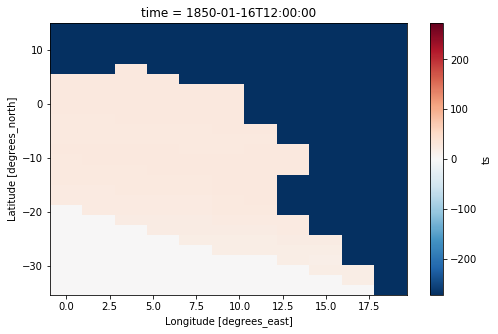

In [98]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
masked = ds0*xr.ones_like(ds0)*ls_mask
masked = masked.isel({'lat': (masked.lat>-35)*(masked.lat<15),'lon': (masked.lon>-28)*(masked.lon<20)})
masked['ts'] = masked['ts'] - 273
new_mask = (masked.lat>4)*(6*masked.lat - 5*masked.lon <164) + (masked.lat<4)*(6*masked.lat + 5*masked.lon > -116)
(masked*xr.ones_like(masked)*new_mask).ts[0].sortby(masked.lon).plot()

In [96]:
gsurl

'gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Amon/ts/gn/v20190627/'

In [ ]:
Sm

In [ ]:
! tree -L 9 ~/CMIP6-downloads #unix tree of created files; I didn't create any.

In [ ]:
! du -sh ~/CMIP6-downloads/*/*/*/*

In [ ]:
ds = xr.open_dataset('/home/naomi/CMIP6-downloads/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/sfcWind/gn/sfcWind.nc')

In [ ]:
ds.sfcWind.plot(vmin=0,vmax=12)

In [ ]:
#Convert longitude coordinates from 0-359 to -180-179:

ds2 = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

#or

ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)

In [ ]:
ds2.sfcWind[0].plot()